In [1]:
!pip install transformers datasets evaluate rouge_score py7zr

!pip install sentencepiece
!pip install transformers
!pip install rich[jupyter]

## 資料分割

In [2]:
from datasets import load_dataset
finconversation = load_dataset("yash1811/news_summaries")

train_data = finconversation['train']
test_data = finconversation['test']
val_data = finconversation['validation']

# def generator(data_split):
#   for instance in data_split:
#     instance['id'], instance['summary'], instance['transcript']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import pandas as pd
df_train = pd.DataFrame()
df_train["transcript"] = train_data['article']
df_train["summary"] = train_data['abstract']


In [4]:
df_train.head()

,transcript,summary
0,The Delhi High Court has asked the government ...,Fill pending vacancies in jails in six months:...
1,Following a review meeting with senior officer...,"Joshimath to get disaster control room, BRO te..."
2,A video showing stones being pelted at former ...,Stones pelted at Yediyurappa's home during pr...
3,Directorate of Revenue Intelligence officers h...,Fake currency notes with ₹2 lakh face value se...
4,At least seven people were killed and 15 other...,"7 killed, 15 injured in blast at firecracker f..."


In [5]:
df_train['summary'] = "summarize: "+df_train['summary']
df_train.head()

,transcript,summary
0,The Delhi High Court has asked the government ...,summarize: Fill pending vacancies in jails in ...
1,Following a review meeting with senior officer...,summarize: Joshimath to get disaster control r...
2,A video showing stones being pelted at former ...,summarize: Stones pelted at Yediyurappa's hom...
3,Directorate of Revenue Intelligence officers h...,summarize: Fake currency notes with ₹2 lakh fa...
4,At least seven people were killed and 15 other...,"summarize: 7 killed, 15 injured in blast at fi..."


In [6]:
df_train.shape

(68791, 2)

## T5 Model 訓練設定

In [7]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

from rich.table import Column, Table
from rich import box
from rich.console import Console

# define a rich console logger
console=Console(record=True)

def display_df(df):
  """display dataframe in ASCII format"""

  console=Console()
  table = Table(Column("source_text", justify="center" ), Column("target_text", justify="center"), title="Sample Data",pad_edge=False, box=box.ASCII)

  for i, row in enumerate(df.values.tolist()):
    table.add_row(row[0], row[1])

  console.print(table)

training_logger = Table(Column("Epoch", justify="center" ),
                        Column("Steps", justify="center"),
                        Column("Loss", justify="center"),
                        title="Training Status",pad_edge=False, box=box.ASCII)

In [8]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Torch Dataset 定義格式

In [9]:
class FinNewsDataset(Dataset):
  """
  Creating a custom dataset for reading the dataset and
  loading it into the dataloader to pass it to the neural network for finetuning the model

  """

  def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.source_len = source_len
    self.summ_len = target_len
    self.target_text = self.data[target_text]
    self.source_text = self.data[source_text]

  def __len__(self):
    return len(self.target_text)

  def __getitem__(self, index):
    source_text = str(self.source_text[index])
    target_text = str(self.target_text[index])

    #cleaning data so as to ensure data is in string type
    source_text = ' '.join(source_text.split())
    target_text = ' '.join(target_text.split())

    source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids': source_ids.to(dtype=torch.long),
        'source_mask': source_mask.to(dtype=torch.long),
        'target_ids': target_ids.to(dtype=torch.long),
        'target_ids_y': target_ids.to(dtype=torch.long)
    }

In [10]:
def train(epoch, tokenizer, model, device, loader, optimizer):

  """
  Function to be called for training with the parameters passed from main function

  """

  model.train()
  for _,data in enumerate(loader, 0):
    y = data['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]

    if _%10==0:
      training_logger.add_row(str(epoch), str(_), str(loss))
      console.print(training_logger)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [11]:
def validate(epoch, tokenizer, model, device, loader):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask,
              max_length=150,
              num_beams=2,
              repetition_penalty=2.5,
              length_penalty=1.0,
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          if _%10==0:
              console.print(f'Completed {_}')

          predictions.extend(preds)
          actuals.extend(target)
  return predictions, actuals


In [12]:
def T5Trainer(dataframe, source_text, target_text, model_params, output_dir="./outputs/" ):

  """
  T5 trainer

  """

  # Set random seeds and deterministic pytorch for reproducibility
  torch.manual_seed(model_params["SEED"]) # pytorch random seed
  np.random.seed(model_params["SEED"]) # numpy random seed
  torch.backends.cudnn.deterministic = True

  # logging
  console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

  # tokenzier for encoding the text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
  # Further this model is sent to device (GPU/TPU) for using the hardware.
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)

  # logging
  console.log(f"[Data]: Reading data...\n")

  # Importing the raw dataset
  dataframe = dataframe[[source_text,target_text]]
  display_df(dataframe.head(2))


  # Creation of Dataset and Dataloader
  # Defining the train size. So 80% of the data will be used for training and the rest for validation.
  train_size = 0.8
  train_dataset=dataframe.sample(frac=train_size,random_state = model_params["SEED"])
  val_dataset=dataframe.drop(train_dataset.index).reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  console.print(f"FULL Dataset: {dataframe.shape}")
  console.print(f"TRAIN Dataset: {train_dataset.shape}")
  console.print(f"TEST Dataset: {val_dataset.shape}\n")


  # Creating the Training and Validation dataset for further creation of Dataloader
  training_set = FinNewsDataset(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)
  val_set = FinNewsDataset(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)


  # Defining the parameters for creation of dataloaders
  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }


  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }


  # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
  training_loader = DataLoader(training_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)


  # Defining the optimizer that will be used to tune the weights of the network in the training session.
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])


  # Training loop
  console.log(f'[Initiating Fine Tuning]...\n')

  for epoch in range(model_params["TRAIN_EPOCHS"]):
      train(epoch, tokenizer, model, device, training_loader, optimizer)

  console.log(f"[Saving Model]...\n")
  #Saving the model after training
  path = os.path.join(output_dir, "model_files")
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)


  # evaluating test dataset
  console.log(f"[Initiating Validation]...\n")
  for epoch in range(model_params["VAL_EPOCHS"]):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
    final_df.to_csv(os.path.join(output_dir,'predictions.csv'))

  console.save_text(os.path.join(output_dir,'logs.txt'))

  console.log(f"[Validation Completed.]\n")
  console.print(f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n""")
  console.print(f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n""")
  console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [13]:
model_params={
    "MODEL":"t5-base",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":2,              # number of training epochs
    "VAL_EPOCHS":1,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":50,   # max length of target text
    "SEED": 42                     # set seed for reproducibility

}


## 觀察轉換過的資料

In [14]:
tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
FinNewsDataset_train = FinNewsDataset(df_train, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text="transcript", target_text="summary")

# Assuming FinNewsDataset_train is an instance of your dataset class
# and you want to inspect the first few samples
num_samples_to_inspect = 5

for i in range(num_samples_to_inspect):
    sample = FinNewsDataset_train[i]
    print(f"Sample {i + 1}:")
    print("Source Text (transcript):", sample['source_ids'])
    print("Target Text (summary):", sample['target_ids'])
    print("=" * 50)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/p

Sample 1:
Source Text (transcript): tensor([   37, 10619,  1592,  2243,    65,  1380,     8,   789,    13,     8,
          868,  5826, 30110,    12,   766,    66,     3, 11577,     3, 22926,
           16, 11796,     7,   365,   165,  6790,    33,  3353,    16,     8,
          416,  1296,   767,     5,    37,     3, 22926,   560,  4655,    13,
         1035,  5803,     6, 11189,   322,     7,     6,  3081,     6,  6325,
         3081,     6,  3856,  2726,  1950,   871,    11, 13454,  5803,     5,
           37,   455,    47,  2804,    57,  4831,     7,  8821,  1273, 12402,
          588, 30405,    11,  3325,  2375,   106,  2552,  6110,     7,     9,
           26,     5,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

In [15]:
len(df_train["transcript"][0])

382

In [16]:
df_train["transcript"][0]

'The Delhi High Court has asked the government of the National Capital Territory to ensure all pending vacancies in jails under its limits are filled in the next six months. The vacancies include positions of medical officers, counsellors, teachers, yoga teachers, paramedical staff and welfare officers. The order was passed by justices Satish Chander Sharma and Subramonium Prasad.'

In [17]:
# Assuming FinNewsDataset_train is an instance of your dataset class
# and you want to inspect the keys of the first sample
sample = FinNewsDataset_train[0]

# Print the keys of the sample dictionary
print("Keys of the Sample Dictionary:", sample.keys())

# Alternatively, you can print the entire dictionary for better understanding
print("Sample Dictionary:", sample)

Keys of the Sample Dictionary: dict_keys(['source_ids', 'source_mask', 'target_ids', 'target_ids_y'])
Sample Dictionary: {'source_ids': tensor([   37, 10619,  1592,  2243,    65,  1380,     8,   789,    13,     8,
          868,  5826, 30110,    12,   766,    66,     3, 11577,     3, 22926,
           16, 11796,     7,   365,   165,  6790,    33,  3353,    16,     8,
          416,  1296,   767,     5,    37,     3, 22926,   560,  4655,    13,
         1035,  5803,     6, 11189,   322,     7,     6,  3081,     6,  6325,
         3081,     6,  3856,  2726,  1950,   871,    11, 13454,  5803,     5,
           37,   455,    47,  2804,    57,  4831,     7,  8821,  1273, 12402,
          588, 30405,    11,  3325,  2375,   106,  2552,  6110,     7,     9,
           26,     5,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

## Summarize Result & Training Process (Loss)

In [18]:
T5Trainer(dataframe=df_train.iloc[:5000], source_text="transcript", target_text="summary", model_params=model_params, output_dir="outputs")

[14:21:05] [Model]: Loading t5-base...                                           <ipython-input-12-0c218427b78c>:14
                                                                                                                   

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[14:21:21] [Data]: Reading data...                                               <ipython-input-12-0c218427b78c>:25
                                                                                                                   

                                                    Sample Data                                                    
+-----------------------------------------------------------------------------------------------------------------+
|                      source_text                       |                       target_text                      |
|--------------------------------------------------------+--------------------------------------------------------|
| The Delhi High Court has asked the government of the   |    summarize: Fill pending vacancies in jails in six   |
|   National Capital Territory to ensure all pending     |                months: HC to Delhi govt                |
| vacancies in jails under its limits are filled in the  |                                                        |
|  next six months. The vacancies include positions of   |                                                        |
|medical officers, counsellors, teachers, yoga teachers, |                                                        |
| paramedical staff and welfare officers. The order was  |                                                        |
|     passed by justices Satish Chander Sharma and       |                                                        |
|                  Subramonium Prasad.                   |                                                        |
|   Following a review meeting with senior officers,     | summarize: Joshimath to get disaster control room, BRO |
| Uttarakhand CM Pushkar Singh Dhami on Tuesday said a   |                   team for Char Dham                   |
|  disaster management control room will be set up in    |                                                        |
| subsidence-hit Joshimath to ensure smooth conduct of   |                                                        |
|  the pilgrimage to Badrinath. He added that a Border   |                                                        |
| Roads Organisation (BRO) team will also be deployed.   |                                                        |
|  "This year's yatra will be historic," Dhami further   |                                                        |
|                         said.                          |                                                        |
+-----------------------------------------------------------------------------------------------------------------+

FULL Dataset: (5000, 2)

TRAIN Dataset: (4000, 2)

TEST Dataset: (1000, 2)

[14:21:22] [Initiating Fine Tuning]...                                           <ipython-input-12-0c218427b78c>:74
                                                                                                                   

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(5.9453, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.3897, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  20   | tensor(2.6763, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  30   | tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  40   | tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  50   | tensor(1.7114, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  60   | tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  70   | tensor(2.2738, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  80   | tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  90   | tensor(1.6769, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  100  | tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  110  | tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  120  | tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  130  | tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  140  | tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  150  | tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  160  | tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  170  | tensor(1.8102, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  180  | tensor(1.4275, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  190  | tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  200  | tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  210  | tensor(1.5603, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  220  | tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  230  | tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  240  | tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  250  | tensor(1.2528, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  260  | tensor(1.3211, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  270  | tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  280  | tensor(1.7479, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  290  | tensor(1.7092, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  300  | tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  310  | tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  320  | tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  330  | tensor(1.4187, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  340  | tensor(1.5060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  350  | tensor(1.5120, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  360  | tensor(1.3495, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  370  | tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  380  | tensor(1.6392, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  390  | tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  400  | tensor(1.2958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  410  | tensor(1.7075, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  420  | tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  430  | tensor(1.7035, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  440  | tensor(1.5220, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  450  | tensor(1.1262, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  460  | tensor(1.3968, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  470  | tenso

[14:38:23] [Saving Model]...                                                     <ipython-input-12-0c218427b78c>:79
                                                                                                                   

[14:38:30] [Initiating Validation]...                                            <ipython-input-12-0c218427b78c>:87
                                                                                                                   

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

[14:40:40] [Validation Completed.]                                               <ipython-input-12-0c218427b78c>:95
                                                                                                                   

[Model] Model saved @ outputs/model_files

[Validation] Generation on Validation data saved @ outputs/predictions.csv

[Logs] Logs saved @ outputs/logs.txt

In [19]:
df_train.shape

(68791, 2)

## 把訓練好的模型應用到測試資料集上

[14:21:05] [Model]: Loading t5-base...                                           <ipython-input-12-0c218427b78c>:14
                                                                                                                   
[14:21:21] [Data]: Reading data...                                               <ipython-input-12-0c218427b78c>:25
                                                                                                                   
FULL Dataset: (5000, 2)
TRAIN Dataset: (4000, 2)
TEST Dataset: (1000, 2)

[14:21:22] [Initiating Fine Tuning]...                                           <ipython-input-12-0c218427b78c>:74
                                                                                                                   
                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                          

Text(0.5, 1.0, 'Training Process')

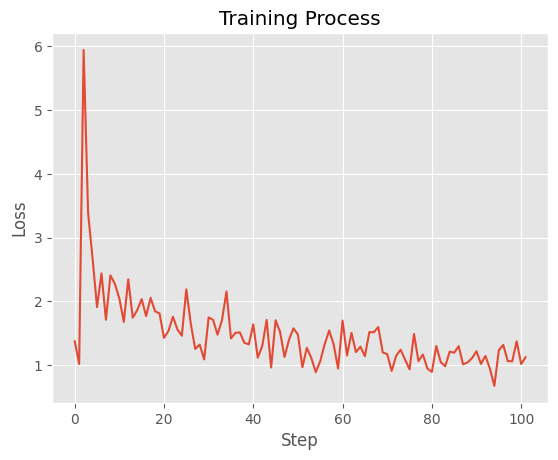

In [20]:
import re
import matplotlib.pyplot as plt

# Open a file in read mode
file_path = '/content/outputs/logs.txt'

try:
    with open(file_path, 'r') as file:
        # Read the entire contents of the file
        content = file.read()
        print(content)
except FileNotFoundError:
    print(f"The file at '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Define a regular expression pattern to extract the numeric values
pattern = re.compile(r'tensor\(([\d.]+)')

# Find all matches in the provided text
matches = pattern.findall(content)

# Convert the matched strings to float values
loss_values = [float(match) for match in matches]

# Print the extracted loss values
print("Extracted Loss Values:", loss_values)
print(loss_values[-5*model_params["TRAIN_EPOCHS"] : ])
final_loss = loss_values[-51*model_params["TRAIN_EPOCHS"] : ]

plt.style.use('ggplot')
plt.plot(final_loss)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Process")

In [21]:
import pandas as pd

prediction_text = pd.read_csv("/content/outputs/predictions.csv")
prediction_text

,Unnamed: 0,Generated Text,Actual Text
0,0,Pune officers seize fake currency notes with f...,summarize: Fake currency notes with 2 lakh fac...
1,1,"7 killed, 15 injured in explosion at firecrack...","summarize: 7 killed, 15 injured in blast at fi..."
2,2,12 people injured in gas cylinder blast at Mad...,summarize: 6-month-old among over 12 hurt afte...
3,3,"3 men assault imam, cut off his beard in Maha",summarize: Imam beaten for allegedly not chant...
4,4,Stones pelted at Union Minister's convoy in Bihar,summarize: Stones pelted at Union Minister Ash...
...,...,...,...
995,995,Mulayam Singh's health condition is critical i...,summarize: SP founder Mulayam Singh's health s...
996,996,bear found dead at Valmiki Tiger Reserve in Bihar,summarize: Bear found dead at Valmiki Tiger Re...
997,997,"'Gucci shoes worth 1.5 lakh, jeans worth 80,00...","summarize: Conman Sukesh cries as footwear, je..."
998,998,CBI gets 946.51 cr in Budget 2023-24,"summarize: CBI allocated 946 cr in Budget, a h..."


In [22]:
from rouge_score import rouge_scorer
import pandas as pd

# Assuming prediction_text is a Pandas DataFrame
# prediction_text["Generated Text"] = prediction_text["Generated Text"].astype(str).apply(lambda x: x.lower())
# prediction_text["Actual Text"] = prediction_text["Actual Text"].astype(str).apply(lambda x: x.lower())

# Initialize Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

# Calculate Rouge scores for each row
scores_list = []
for index, row in prediction_text.iterrows():
    scores = scorer.score(row["Generated Text"], row["Actual Text"])
    scores_list.append(scores)

scores_df = pd.DataFrame(scores_list)

# Extract and print the F-measure
f_measure_rouge1 = scores_df['rouge1'].apply(lambda x: x.fmeasure)
precision_rouge1 = scores_df['rouge1'].apply(lambda x: x.precision)
print("F-measure for Rouge1:", f_measure_rouge1.mean())
print("Precision for Rouge1:", precision_rouge1.mean())

F-measure for Rouge1: 0.5381584236180609
Precision for Rouge1: 0.49775655090523513


In [23]:
scores

{'rouge1': Score(precision=0.36363636363636365, recall=0.4, fmeasure=0.380952380952381)}